## Início da preparação dos dados

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
import matplotlib
import pickle
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import log_loss, f1_score
from pycaret.classification import *



# Configurações de fonte e supressão de warnings que estavam ocorrendo
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.font_manager')

# Leitura dos dados tipo parquet da base de desenvolvimento
df = pd.read_parquet("../data/01_raw/dataset_kobe_dev.parquet")

# Seleção de colunas e remoção de nulos
colunas = [
    "lat", "lon", "minutes_remaining", "period",
    "playoffs", "shot_distance", "shot_made_flag"
]
filtered_df = df[colunas].dropna()

# Visualização dos tipos de variáveis presentes nas colunas selecionadas
for col, tipo in filtered_df.dtypes.items():
    print(f"{col}: {tipo}")

# Modificação do shot_made_flag de float para int. 
filtered_df["shot_made_flag"] = filtered_df["shot_made_flag"].astype(int)

# Estatísticas antes da normalização
print("Médias antes da normalização:")
print(filtered_df.mean(numeric_only=True))
print("\nDesvios padrão antes da normalização:")
print(filtered_df.std(numeric_only=True))

# Histograma das variáveis antes da normalização
plt.figure(figsize=(16, 12))
for i, coluna in enumerate(colunas[:-1]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(filtered_df[coluna], kde=True)
    plt.title(f"{coluna} (original)")
plt.tight_layout()
plt.show()

# Verificando valores únicos nas colunas categóricas
print("\nValores únicos em playoffs")
print(filtered_df["playoffs"].unique())

print("\nValores únicos em period")
print(filtered_df["period"].unique())

print("\nValores únicos em shot_made_flag")
print(filtered_df["shot_made_flag"].unique())

# Salvando no local adequado a base de dados filtrada
filtered_df.to_parquet("data/03_primary/base_train.parquet", index=False)


FileNotFoundError: [Errno 2] No such file or directory: '../data/01_raw/dataset_kobe_dev.parquet'

Médias após a normalização:
lat                 -0.158093
lon                  0.063472
minutes_remaining    0.016695
period              -0.264013
playoffs             0.148731
shot_distance       -0.111480
dtype: float64

Desvios padrão após a normalização:
lat                  0.558428
lon                  0.791538
minutes_remaining    0.570644
period               0.574096
playoffs             0.355831
shot_distance        0.472472
dtype: float64


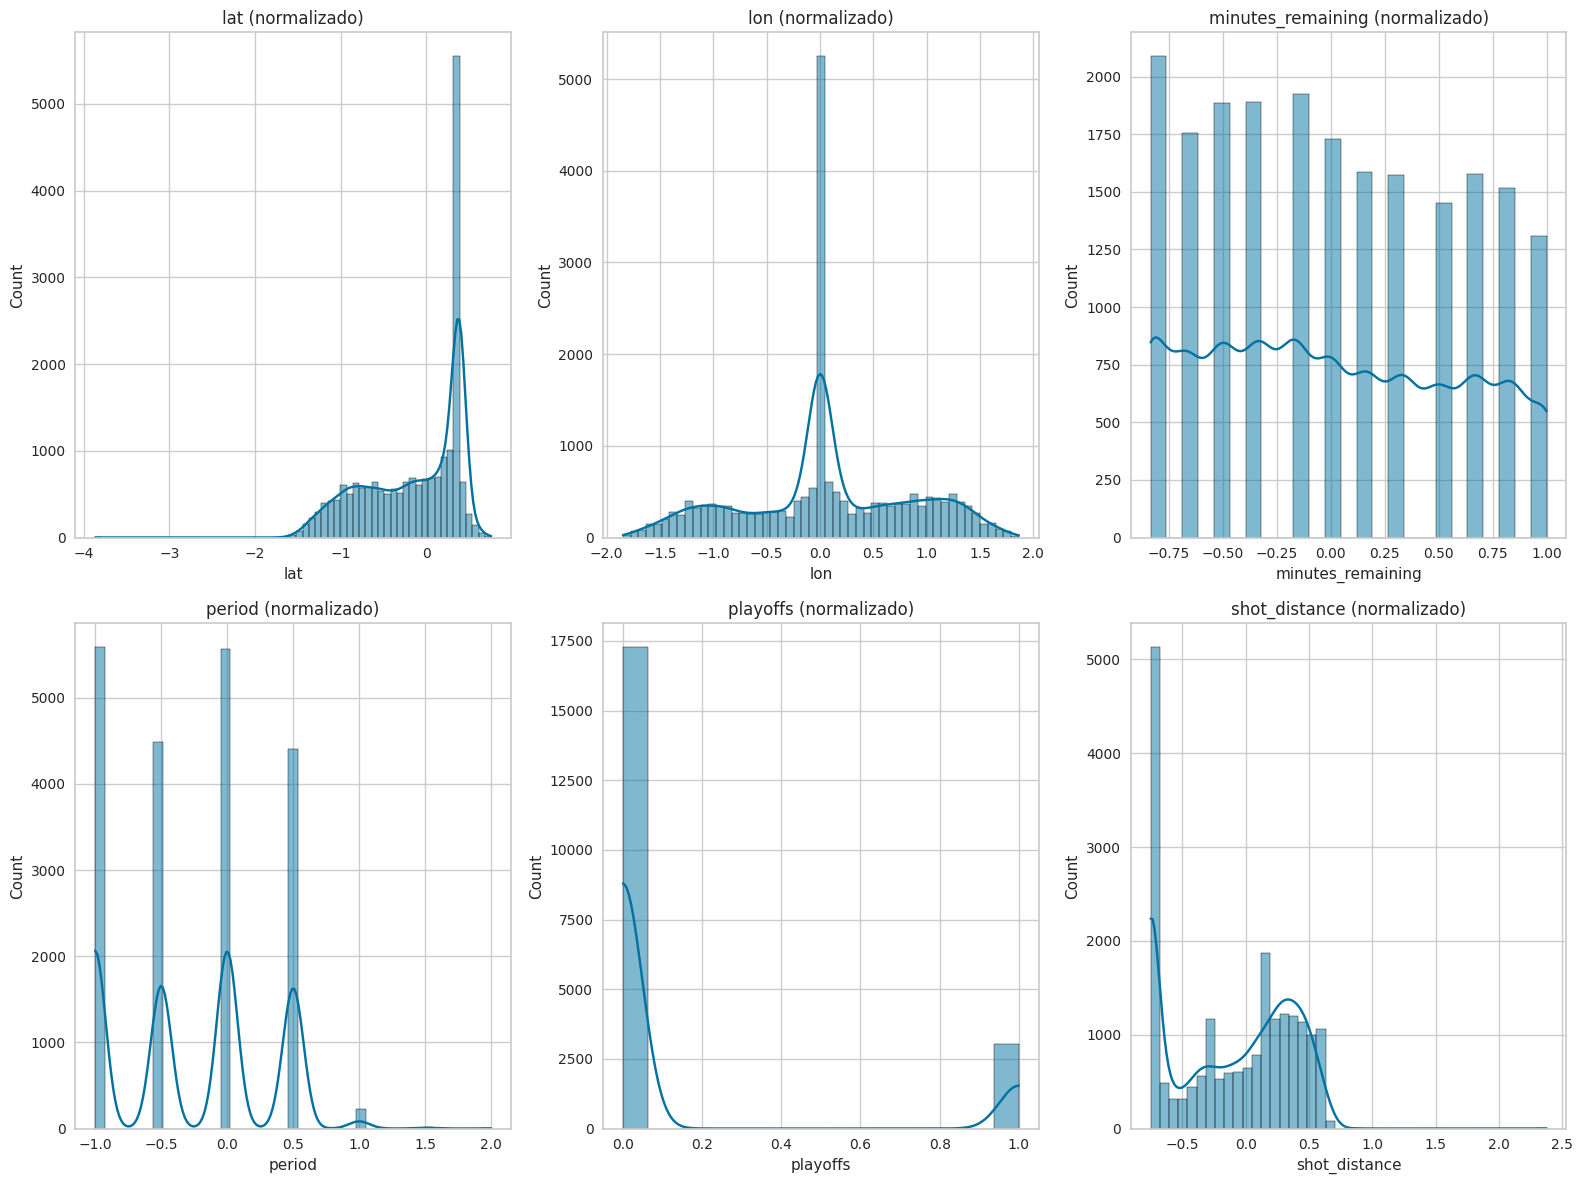

Train shape: (16228, 6)
Test shape: (4057, 6)


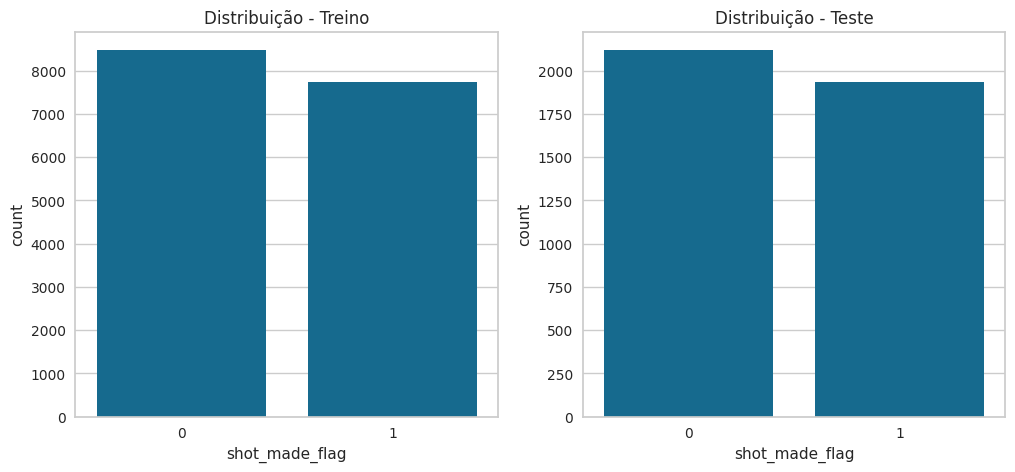

In [122]:
# Separação de X e y
X = filtered_df.drop(columns=["shot_made_flag"])
y = filtered_df["shot_made_flag"]

# Normalização robusta 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Salvar o scaler para uso posterior no streamlit
scaler_output_path = "../data/06_models"
os.makedirs(scaler_output_path, exist_ok=True)
with open(f"{scaler_output_path}/robust_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Estatísticas após a normalização
print("Médias após a normalização:")
print(X_scaled.mean())
print("\nDesvios padrão após a normalização:")
print(X_scaled.std())

# Histograma das variáveis após a normalização
plt.figure(figsize=(16, 12))
for i, coluna in enumerate(X_scaled.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_scaled[coluna], kde=True)
    plt.title(f"{coluna} (normalizado)")
plt.tight_layout()
plt.show()

# Separação dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=8
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Balanceamento de classes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Distribuição - Treino")
sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title("Distribuição - Teste")
plt.show()

# Garantir alinhamento de índice e salvando no local adequado
train_df = X_train.reset_index(drop=True).copy()
train_df["shot_made_flag"] = y_train.reset_index(drop=True)
train_df.to_parquet("../data/05_model_input/base_train.parquet", index=False)

test_df = X_test.reset_index(drop=True).copy()
test_df["shot_made_flag"] = y_test.reset_index(drop=True)
test_df.to_parquet("../data/05_model_input/base_test.parquet", index=False)



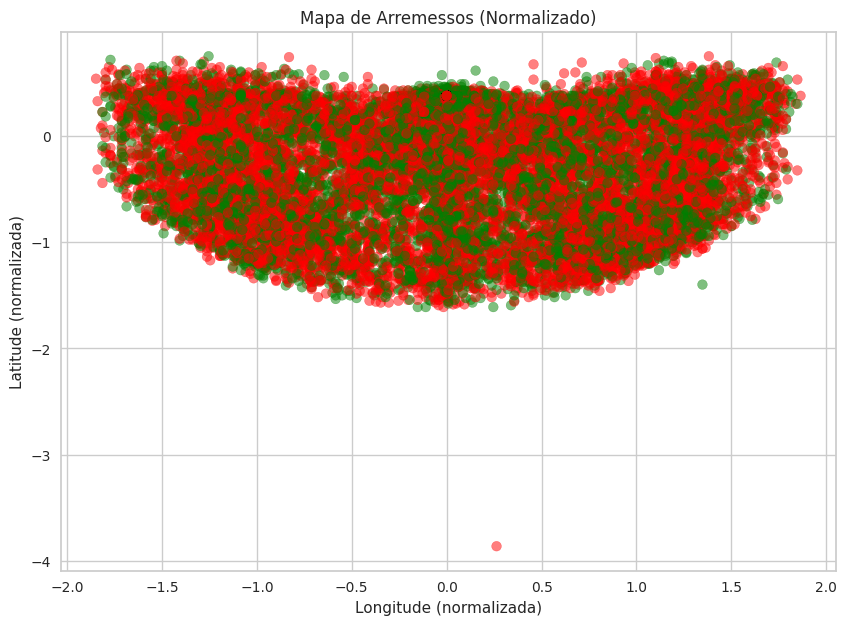

In [123]:
# Visualização dos arremessos com coordenadas normalizadas
plt.figure(figsize=(10, 7))

cores = ["green" if v == 1 else "red" for v in y]
plt.scatter(X_scaled["lon"], X_scaled["lat"], c=cores, alpha=0.5)

plt.title("Mapa de Arremessos (Normalizado)")
plt.xlabel("Longitude (normalizada)")
plt.ylabel("Latitude (normalizada)")
plt.grid(True)
plt.show()

## Final da preparação dos dados

## Início do treinamento de modelos

In [124]:
import mlflow

# Define o caminho onde as runs ficarão salvas
mlflow.set_tracking_uri("file:../mlruns")  # ou o caminho que preferir

# Define o experimento (será criado se não existir)
mlflow.set_experiment("TreinamentoKobe")

<Experiment: artifact_location='file:///workspaces/kobe-pd/notebooks/../mlruns/674157820746787100', creation_time=1744664096988, experiment_id='674157820746787100', last_update_time=1744664096988, lifecycle_stage='active', name='TreinamentoKobe', tags={}>

In [125]:
# Carregar os dados
df_train = pd.read_parquet("../data/05_model_input/base_train.parquet")
df_test = pd.read_parquet("../data/05_model_input/base_test.parquet")

# Inicializar experimento com PyCaret
exp = setup(
    data=df_train,
    target="shot_made_flag",
    session_id=22,
    normalize=True,
    normalize_method="robust",
    log_experiment=False,
    experiment_name="Treinamento_PyCaret"
)

# Criar o modelo
model = create_model("lr")

# Ajustar hiperparâmetros
tuned_model = tune_model(model, optimize="F1", n_iter=100)

# Obter e salvar os resultados da validação cruzada
results_lr = pull()
results_lr["Model"] = "Logistic Regression"

# Previsões no conjunto de teste
predictions = predict_model(tuned_model, data=df_test)

# Calcular log loss no teste
eps = 1e-15
pred_probs = np.clip(predictions["prediction_score"], eps, 1 - eps)
log_loss_value = log_loss(predictions["shot_made_flag"], pred_probs)
results_lr["log_loss"] = log_loss_value

# Ver resultados
print("\n🔧 Melhores hiperparâmetros:") # Seria registrado no MLFLOW
print(tuned_model.get_params())

print(f"\n📈 F1 Score (validação cruzada): {results_lr['F1'].max():.4f}") # Seria registrado no MLFLOW
print(f"📉 Log Loss (teste): {log_loss_value:.4f}") # Seria registrado no MLFLOW

save_model(tuned_model, "../data/06_models/model_regression_logistic_prod");

# Registrar tudo no MLflow assumindo que a run já está ativa
mlflow.set_tag("mlflow.runName", "Treinamento_LogisticRegression")
mlflow.log_param("modelo_logreg", "Logistic Regression")
mlflow.log_param("n_ite_r_logreg", 100)
mlflow.log_param("scaler_logreg", "RobustScaler")

# Hiperparâmetros
for param, value in tuned_model.get_params().items():
    mlflow.log_param(f"param_{param}", value)

# Métricas
mlflow.log_metric("f1_score_logreg", results_lr["F1"].max())
mlflow.log_metric("log_loss_logreg", log_loss_value)

# Log do modelo treinado
mlflow.sklearn.log_model(tuned_model, "model_lr")


,Description,Value
0,Session id,22
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(16228, 7)"
4,Transformed data shape,"(16228, 7)"
5,Transformed train set shape,"(11359, 7)"
6,Transformed test set shape,"(4869, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5819,0.6004,0.4797,0.5740,0.5226,0.1559,0.1579
1,0.5731,0.5991,0.5074,0.5578,0.5314,0.1409,0.1415
2,0.5898,0.6153,0.4908,0.5833,0.5331,0.1721,0.1741
3,0.5739,0.5971,0.4908,0.5612,0.5236,0.1414,0.1424
4,0.5819,0.5920,0.5148,0.5682,0.5402,0.1585,0.1592
5,0.5783,0.6179,0.4760,0.5695,0.5186,0.1488,0.1507
6,0.5854,0.5861,0.4871,0.5777,0.5285,0.1633,0.1652
7,0.5739,0.5883,0.4549,0.5678,0.5051,0.1390,0.1417
8,0.5924,0.6118,0.5304,0.5806,0.5544,0.1803,0.1809


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5766,0.6005,0.5387,0.5583,0.5484,0.1501,0.1502
1,0.5722,0.5991,0.5572,0.5511,0.5541,0.1430,0.1430
2,0.5951,0.6152,0.5664,0.5771,0.5717,0.1878,0.1878
3,0.5616,0.5972,0.5314,0.5414,0.5363,0.1207,0.1207
4,0.5651,0.5920,0.5572,0.5432,0.5501,0.1294,0.1295
5,0.5783,0.6180,0.5387,0.5605,0.5494,0.1535,0.1536
6,0.5810,0.5861,0.5406,0.5635,0.5518,0.1587,0.1588
7,0.5660,0.5884,0.4917,0.5517,0.5200,0.1264,0.1271
8,0.5845,0.6119,0.5838,0.5631,0.5732,0.1687,0.1688


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5654,0.5894,0.5318,0.5461,0.5388,0.1281,0.1282



🔧 Melhores hiperparâmetros:
{'C': 8.731, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 22, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

📈 F1 Score (validação cruzada): 0.5732
📉 Log Loss (teste): 0.7131
Transformation Pipeline and Model Successfully Saved


In [126]:
# Criar e ajustar modelo Decision Tree
dt_model = create_model("dt")
tuned_dt_model = tune_model(dt_model, optimize="F1", n_iter=100) # Seria registrado no MLFLOW
results_dt = pull()
results_dt["Model"] = "Decision Tree"

# Previsões e log loss no teste
dt_predictions = predict_model(tuned_dt_model, data=df_test) 
eps = 1e-15
dt_pred_probs = np.clip(dt_predictions["prediction_score"], eps, 1 - eps)
log_loss_dt = log_loss(dt_predictions["shot_made_flag"], dt_pred_probs)
results_dt["log_loss"] = log_loss_dt

# Saída final
print(f"\n📈 F1 Score (validação cruzada): {results_dt['F1'].max():.4f}") # Seria registrado no MLFLOW
print(f"📉 Log Loss (teste): {log_loss_dt:.4f}") # Seria registrado no MLFLOW

save_model(tuned_dt_model, "../data/06_models/model_decision_tree_prod");

# Registrar parâmetros e métricas no MLflow
mlflow.log_param("modelo_dt", "Decision Tree")
mlflow.log_param("n_iter_dt", 100)
mlflow.log_param("scaler_dt", "RobustScaler")

for param, value in tuned_dt_model.get_params().items():
    mlflow.log_param(f"param_dt_{param}", value)

mlflow.log_metric("f1_score_dt", results_dt["F1"].max())
mlflow.log_metric("log_loss_dt", log_loss_dt)




,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5519,0.5420,0.5959,0.5269,0.5593,0.1071,0.1080
1,0.5335,0.5233,0.5775,0.5098,0.5415,0.0703,0.0709
2,0.5405,0.5185,0.5756,0.5166,0.5445,0.0836,0.0841
3,0.5097,0.4835,0.5443,0.4876,0.5144,0.0223,0.0224
4,0.5458,0.5264,0.5756,0.5217,0.5474,0.0937,0.0942
5,0.5396,0.5243,0.5886,0.5153,0.5495,0.0830,0.0838
6,0.5299,0.5150,0.5369,0.5070,0.5215,0.0603,0.0604
7,0.5502,0.5432,0.5783,0.5268,0.5514,0.1023,0.1027
8,0.5590,0.5377,0.6004,0.5344,0.5655,0.1208,0.1217


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5687,0.5705,0.4668,0.5573,0.5080,0.1293,0.1309
1,0.5607,0.5718,0.4926,0.5438,0.5169,0.1160,0.1165
2,0.5766,0.5844,0.5111,0.5619,0.5353,0.1480,0.1486
3,0.5607,0.5624,0.4502,0.5483,0.4944,0.1127,0.1144
4,0.5528,0.5426,0.4649,0.5362,0.4980,0.0985,0.0993
5,0.5845,0.5806,0.4225,0.5902,0.4925,0.1568,0.1631
6,0.5607,0.5564,0.4299,0.5508,0.4829,0.1111,0.1137
7,0.5607,0.5713,0.5028,0.5438,0.5225,0.1170,0.1173
8,0.5757,0.5801,0.5378,0.5583,0.5478,0.1484,0.1485


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5196,0.5035,0.5601,0.4973,0.5268,0.0425,0.0428



📈 F1 Score (validação cruzada): 0.5478
📉 Log Loss (teste): 15.3255
Transformation Pipeline and Model Successfully Saved


📊 Comparação Final dos Modelos:


,Model,F1 Score (Val. Cruzada),Log Loss (Teste)
0,Logistic Regression,0.5732,0.713124
1,Decision Tree,0.5478,15.325539


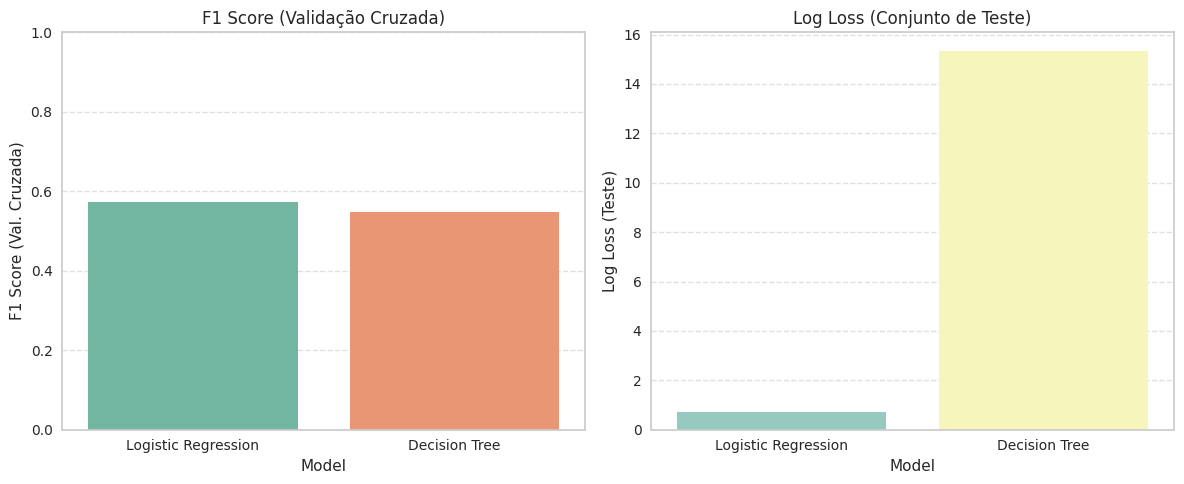

In [127]:
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "F1 Score (Val. Cruzada)": [results_lr["F1"].max(), results_dt["F1"].max()],
    "Log Loss (Teste)": [results_lr["log_loss"].iloc[0], results_dt["log_loss"].iloc[0]]
})

# Exibir a tabela
print("📊 Comparação Final dos Modelos:")
display(comparison_df)

# Gráficos comparativos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F1
sns.barplot(x="Model", y="F1 Score (Val. Cruzada)", data=comparison_df, palette="Set2", ax=axes[0])
axes[0].set_title("F1 Score (Validação Cruzada)")
axes[0].set_ylim(0, 1)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# Log Loss
sns.barplot(x="Model", y="Log Loss (Teste)", data=comparison_df, palette="Set3", ax=axes[1])
axes[1].set_title("Log Loss (Conjunto de Teste)")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

## Fim do treinamento

## Início da Aplicação

In [128]:
# Carregar dados de produção
df_prod = pd.read_parquet("../data/01_raw/dataset_kobe_prod.parquet")

# Selecionar as colunas relevantes e remover nulos
colunas = [
    "lat", "lon", "minutes_remaining", "period",
    "playoffs", "shot_distance", "shot_made_flag"
]
df_prod = df_prod[colunas].dropna()

# Separar X e y
X_prod = df_prod.drop(columns=["shot_made_flag"])
y_prod = df_prod["shot_made_flag"]

# Carregar o modelo treinado com PyCaret
model = load_model("../data/06_models/model_regression_logistic_prod")

# Fazer previsões com o pipeline completo
resultados = predict_model(model, data=X_prod)

# Avaliar métricas
y_pred = resultados["prediction_label"]
y_score = resultados["prediction_score"]
f1 = f1_score(y_prod, y_pred)
loss = log_loss(y_prod, y_score)

# Registrar no MLflow
mlflow.set_tag("mlflow.runName", "PipelineAplicacao")
mlflow.log_metric("f1_score_app", f1)
mlflow.log_metric("log_loss_app", loss)

# Salvar resultados como artefato .parquet
df_resultado = X_prod.copy()
df_resultado["shot_made_flag"] = y_prod
df_resultado["prediction"] = y_pred
df_resultado["prediction_score"] = y_score

df_resultado.to_parquet("../data/07_model_output/predictions_prod.parquet", index=False)
mlflow.log_artifact("../data/07_model_output/predictions_prod.parquet", artifact_path="app_output")

# Exibir resultados
print(f"📈 F1 Score (prod): {f1:.4f}")
print(f"📉 Log Loss (prod): {loss:.4f}")

Transformation Pipeline and Model Successfully Loaded


📈 F1 Score (prod): 0.0000
📉 Log Loss (prod): 24.1700


In [129]:
mlflow.end_run()